In [1]:
using Plots
theme(:dark)
using LinearAlgebra, PreallocationTools, ForwardDiff, DiffResults

In [44]:
nₓ = 128
Δx = 2π/nₓ
tstart = 0.
tstop = 2.
rank = 2
nₜ = 32
Δt = (tstop-tstart)/(nₜ+1)

# preallocations
x_new = zeros(nₓ)
y_new = zeros(nₓ)

# set initial condition
x = Array(range(0., 2π - Δx, nₓ))
# bump = exp.(-20*(π .- x).^2)
bump = ones(nₓ)
y = sin.(x) + 2*ones(nₓ)
y2 = sin.(x) + 1e-1*bump + 2*ones(nₓ)
Ψ = rand(nₓ, rank)

# preallocated caches that support ForwardDiff:
struct burger_app
    x_d::DiffCache
    y_d::DiffCache
end
burger = burger_app(
    DiffCache(x_new),
    DiffCache(y_new),
);

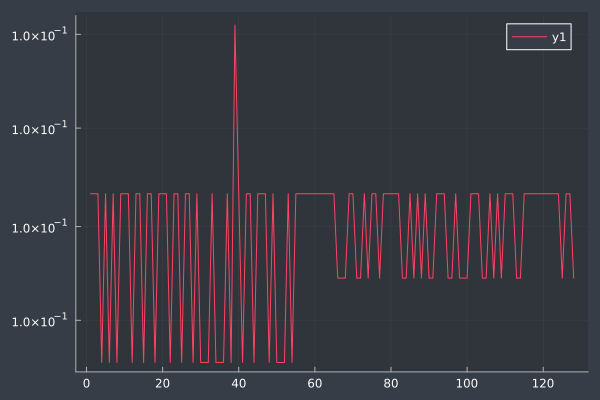

In [45]:
plot(y2 - y)

In [46]:
function interp_periodic(coord, f)
    bound = nₓ
    # r, i = modf(coord / Δx)
    scaled = coord / Δx
    i = trunc(scaled)
    r = scaled - i
    i = mod1(Int(i+1), bound)
    (1 - r)*f[i] + r*f[mod1(i+1, bound)]
end

function semi_lagrangian(burger::burger_app, y, Δt)
    # load preallocated arrays from caches 
    # (loads normal data for y::Real, diffcache for y::Dual)
    x_back = get_tmp(burger.x_d, y)
    y_intp = get_tmp(burger.y_d, y)

    x_back .= x .- Δt * y
    y_intp .= interp_periodic.(x_back, Ref(y))
    y .= y_intp
    return y
end

semi_lagrangian (generic function with 1 method)

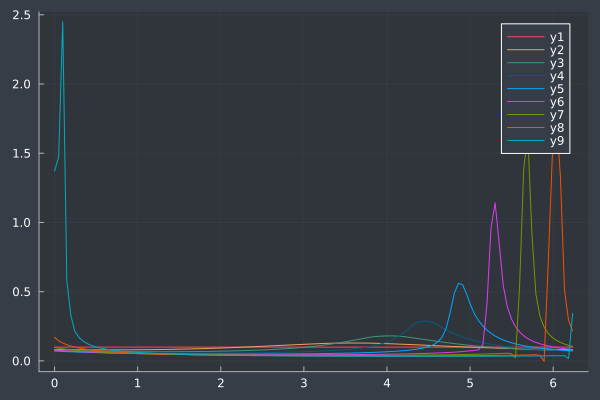

In [47]:
p = plot(x, y2-y)
for t in 1:nₜ
    y = semi_lagrangian(burger, y, Δt)
    y2 = semi_lagrangian(burger, y2, Δt)
    t % 4 == 0 && plot!(x, y2-y)
end

display(p)

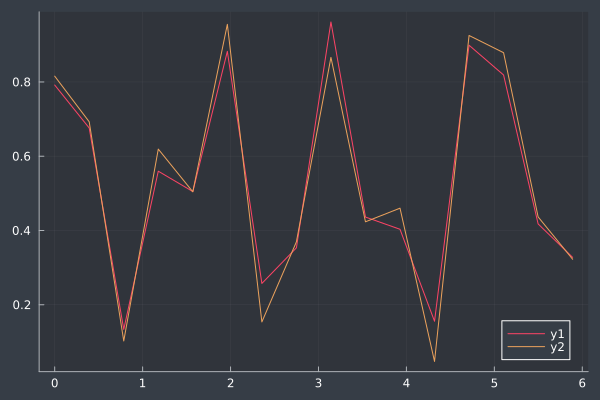

In [21]:
d = ForwardDiff.derivative(0.) do r
    semi_lagrangian(burger::burger_app, y + Ψ[:,2]*r, Δt)
end
plot(x, d)
plot!(x, Ψ[:,2])

In [22]:
y_new .= y
Ψ_new = deepcopy(Ψ)
result = DiffResults.DiffResult(y_new, Ψ_new)
perturb = r -> semi_lagrangian(burger, y_new + Ψ_new*r, Δt)
result = ForwardDiff.jacobian!(result, perturb, zeros(rank))
result.derivs[1]

16×2 Matrix{Float64}:
 0.20431    0.791746
 0.296009   0.675933
 0.0806617  0.133476
 0.541068   0.559626
 0.498123   0.504789
 0.468267   0.882446
 0.390067   0.257381
 0.917405   0.353293
 1.07902    0.961482
 0.410237   0.43613
 0.6314     0.403218
 0.139798   0.155535
 0.0528431  0.89889
 0.135389   0.818653
 0.816909   0.41767
 0.850342   0.327484

In [23]:
result.value

16-element Vector{Float64}:
  0.0
  0.18986535116051922
  0.3728309793643733
  0.5441951410626736
  0.6963283830613499
  0.8148170764439828
  0.8664868152567595
  0.7495919427789381
  2.2606484837444273e-14
 -0.7495919427789342
 -0.8664868152567601
 -0.8148170764439849
 -0.696328383061352
 -0.544195141062676
 -0.3728309793643755
 -0.18986535116052272